In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os
import torch
import cv2
import cPickle
import numpy as np

import network
from wsddn import WSDDN
from utils.timer import Timer
from fast_rcnn.nms_wrapper import nms

from fast_rcnn.bbox_transform import bbox_transform_inv, clip_boxes
from datasets.factory import get_imdb
from fast_rcnn.config import cfg, cfg_from_file, get_output_dir
import logger
from matplotlib import pyplot as plt

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


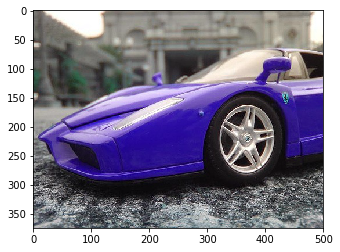

In [5]:
imdb_name = 'voc_2007_trainval'
imdb = get_imdb(imdb_name)
img_path=imdb.image_path_at(2018)
img_path
img= cv2.imread(img_path)
cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [46]:
roidb = imdb.roidb

voc_2007_trainval ss roidb loaded from /home/ubuntu/aws_share/sol/hw2-solution/code/data/cache/voc_2007_trainval_selective_search_roidb.pkl


In [82]:
roi_boxes = roidb[2018]
roi_boxes['boxes'].shape

(2853, 4)

In [94]:
roi_boxes['boxes'][0]

array([ 11,  59, 499, 306], dtype=int32)

In [87]:
roi_boxes['boxscores'].shape
# img

(5705, 1)

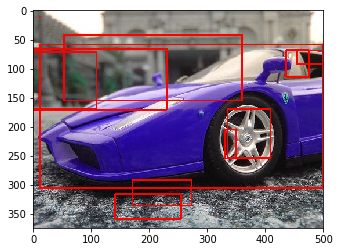

In [95]:
for i in range(10):
    box = roi_boxes['boxes'][100*i]        
    cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),(255,0,0),2)    
plt.imshow(img) 

In [66]:
img_name=img_path[-10:-4]
img_name

'003998'

In [67]:
dictionary = imdb._load_pascal_annotation(img_name)

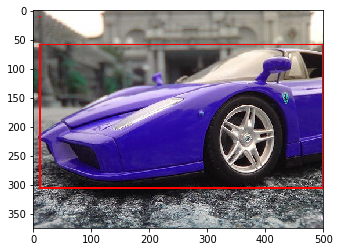

In [74]:
gt_boxes = dictionary['boxes']
for box in gt_boxes:
    cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),(255,0,0),2)
plt.imshow(img)

In [75]:
dictionary

{'boxes': array([[ 11,  59, 499, 306]], dtype=uint16),
 'flipped': False,
 'gt_classes': array([7], dtype=int32),
 'gt_overlaps': <1x21 sparse matrix of type '<type 'numpy.float32'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 'seg_areas': array([121272.], dtype=float32)}

In [ ]:
def vis_detections(im, class_name, dets, thresh=0.8):
    """Visual debugging of detections."""
#     import pdb; pdb.set_trace()
    for i in range(np.minimum(10, dets.shape[0])):
        bbox = tuple(int(np.round(x)) for x in dets[i, :4])
        score = dets[i, -1]
        if score > thresh:
            cv2.rectangle(im, bbox[0:2], bbox[2:4], (0, 204, 0), 2)
            cv2.putText(im, '%s: %.3f' % (class_name, score), (bbox[0], bbox[1] + 15), cv2.FONT_HERSHEY_PLAIN,
                        1.0, (0, 0, 255), thickness=1)
            


for j in xrange(1, imdb.num_classes+1):
    newj = j-1
    inds = np.where(scores[:, newj] > thresh)[0]
    cls_scores = scores[inds, newj] # scores = (4003, 20)
    cls_boxes = boxes[inds, newj * 4:(newj + 1) * 4] # boxes = (4003, 80)
    cls_dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])) \
        .astype(np.float32, copy=False)
    keep = nms(cls_dets, cfg.TEST.NMS)
    cls_dets = cls_dets[keep, :]
    # temp
    if visualize:
#                 import pdb; pdb.set_trace()
#                 im2show = vis_detections(im2show, imdb.classes[newj], cls_dets)
        im2show = vis_detections(im2show, imdb.classes[j], np.hstack((boxes[:,:4],scores[:,newj:newj+1])), thresh=1e-4)

    all_boxes[j][i] = cls_dets